In [25]:
import sqlite3
import os
import polars as pl
import plot
import matplotlib.pyplot as plt
import numpy as np

## Connect + Read from Database

### Set connection parameters

In [90]:
db_dir = "/scratch/aneeshr/concurrent-quit/results/db"
db_name = "db_r_july3"
db_path = db_dir + "/" + db_name

In [91]:
connection = sqlite3.connect(db_path)

### Set the date/timestamp to read

In [70]:
date_to_read = "2025-07-02"

In [29]:
read_index_bench_query = f"SELECT * from index_bench where timestamp > {date_to_read};"

### Read the data

In [103]:
df = pl.read_database(
    query = read_index_bench_query, 
    connection = connection)

### Sample Read Data

In [113]:
filter_col = "index_type"
filter_predicate = "concurrent_quit_appends"

In [114]:
sample_filtered_result = df.filter(pl.col(filter_col) == filter_predicate)

In [115]:
sample_filtered_result

id,timestamp,index_type,workload_file,N,K,L,threads,preload_time,raw_writes_time,raw_reads_time,mixed_time,updates_time,short_range_time,mid_range_time,long_range_time,size,height,internal,leaves,fast_inserts,redistribute,soft_resets,hard_resets,fast_inserts_fail,sort
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,"""2025-07-03 13:24:05.330750+00:…","""concurrent_quit_appends""","""500_0_0""",500,0,0,1,37319841591,0,0,0,34565993672,0,0,0,500000000,3,3921,999999,499000001,0,0,0,999999,0
2,"""2025-07-03 13:26:38.980688+00:…","""concurrent_quit_appends""","""500_5_100""",500,5,100,1,64102847341,0,0,0,33391454083,0,0,0,500000000,3,5177,1398264,458167399,0,0,769522,41832601,1580653
3,"""2025-07-03 13:33:02.326787+00:…","""concurrent_quit_appends""","""500_50_100""",500,50,100,1,199821864139,0,0,0,33033353298,0,0,0,500000000,3,5161,1663797,267462697,0,0,1889153,232537303,1591177
7,"""2025-07-03 13:49:04.416885+00:…","""concurrent_quit_appends""","""500_0_0""",500,0,0,2,105901231866,0,0,0,18343499128,0,0,0,500000000,3,3920,999907,498970009,0,0,0,1029991,999735
8,"""2025-07-03 13:52:56.319551+00:…","""concurrent_quit_appends""","""500_5_100""",500,5,100,2,158290489830,0,0,0,17769098745,0,0,0,500000000,3,5176,1398965,457674603,0,0,769899,42325397,1670442
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
20,"""2025-07-03 20:43:29.442801+00:…","""concurrent_quit_appends""","""500_5_100""",500,5,100,8,251686473370,0,0,0,7605254681,0,0,0,500000000,3,5176,1421421,444224989,0,0,767964,55775011,1657881
21,"""2025-07-03 20:56:44.356690+00:…","""concurrent_quit_appends""","""500_50_100""",500,50,100,8,636337604493,0,0,0,7534125107,0,0,0,500000000,3,5176,1670791,260390977,0,0,1806121,239609023,1551414
25,"""2025-07-03 21:53:38.413384+00:…","""concurrent_quit_appends""","""500_0_0""",500,0,0,16,234575550526,0,0,0,6397875160,0,0,0,500000000,3,3899,994416,495827392,0,0,0,4172608,992594


## Analysis

### Preload times

In [109]:
reset_df = df.select(
            pl.col("N"),
            pl.col("index_type"),
            pl.col("K"),
            pl.col("threads"),
            pl.col("preload_time"),
            # pl.col("hard_resets")
)
# reset_df = reset_df.filter((pl.col("index_type")=="concurrent_quit_appends") & (pl.col("K")==5))
reset_df = reset_df.filter(((pl.col("index_type")=="concurrent_quit_appends") | 
                            (pl.col("index_type")=="concurrent_quit_atomic")) &
                           (pl.col("K")==50))
print(reset_df)

shape: (10, 5)
┌─────┬─────────────────────────┬─────┬─────────┬──────────────┐
│ N   ┆ index_type              ┆ K   ┆ threads ┆ preload_time │
│ --- ┆ ---                     ┆ --- ┆ ---     ┆ ---          │
│ i64 ┆ str                     ┆ i64 ┆ i64     ┆ i64          │
╞═════╪═════════════════════════╪═════╪═════════╪══════════════╡
│ 500 ┆ concurrent_quit_appends ┆ 50  ┆ 1       ┆ 199821864139 │
│ 500 ┆ concurrent_quit_atomic  ┆ 50  ┆ 1       ┆ 193265251521 │
│ 500 ┆ concurrent_quit_appends ┆ 50  ┆ 2       ┆ 479438509646 │
│ 500 ┆ concurrent_quit_atomic  ┆ 50  ┆ 2       ┆ 270270925717 │
│ 500 ┆ concurrent_quit_appends ┆ 50  ┆ 4       ┆ 619340456498 │
│ 500 ┆ concurrent_quit_atomic  ┆ 50  ┆ 4       ┆ 339225342397 │
│ 500 ┆ concurrent_quit_appends ┆ 50  ┆ 8       ┆ 636337604493 │
│ 500 ┆ concurrent_quit_atomic  ┆ 50  ┆ 8       ┆ 422626145332 │
│ 500 ┆ concurrent_quit_appends ┆ 50  ┆ 16      ┆ 575216435738 │
│ 500 ┆ concurrent_quit_atomic  ┆ 50  ┆ 16      ┆ 435211586708 │
└─────┴───

In [105]:
preload_df = df.select(
                pl.col("index_type"), 
                pl.col("K"),
                pl.col("threads"),
                pl.col("updates_time")
)

In [106]:
num_ops = 5e6
div_factor = num_ops * 1000
preload_df = preload_df.with_columns((div_factor/pl.col("updates_time")).alias("throughput"))
preload_df

index_type,K,threads,updates_time,throughput
str,i64,i64,i64,f64
"""concurrent_quit_appends""",0,1,34565993672,0.144651
"""concurrent_quit_appends""",5,1,33391454083,0.149739
"""concurrent_quit_appends""",50,1,33033353298,0.151362
"""concurrent_quit_atomic""",0,1,34352683482,0.145549
"""concurrent_quit_atomic""",5,1,33302189547,0.15014
…,…,…,…,…
"""concurrent_quit_appends""",5,16,6229009358,0.802696
"""concurrent_quit_appends""",50,16,6522306255,0.7666
"""concurrent_quit_atomic""",0,16,6621239506,0.755146


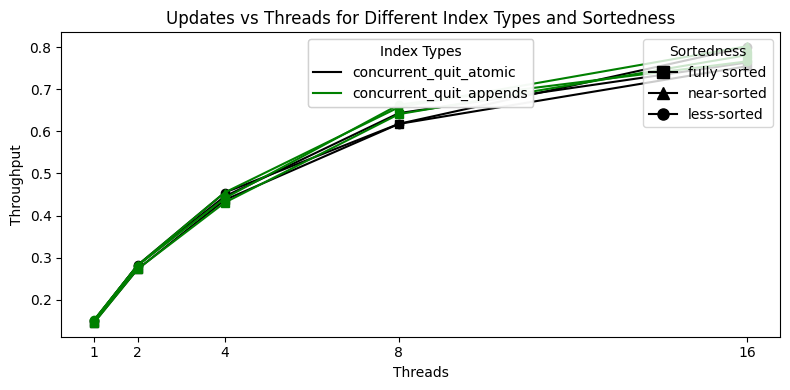

In [107]:
index_types = preload_df["index_type"].unique().to_list()
k_values = sorted(preload_df["K"].unique().to_list())
thread_values = sorted(preload_df["threads"].unique().to_list())

colors = {"concurrent_simple": "grey", "concurrent_quit": "blue", 
          "concurrent_quit_appends": "green", "concurrent_quit_atomic": "black"}
markers = {k: ['s', '^', 'o'][i % 3] for i, k in enumerate(k_values)}
sortedness_values = {0: "fully sorted", 5: "near-sorted", 50: "less-sorted"}

plt.figure(figsize=(8, 4))
lines = []
labels = []
for index in index_types:
    # Filter DataFrame by the current index type
    index_df = preload_df.filter(pl.col("index_type") == index).sort(["K", "threads"])
    # Iterate through each K value
    for k in k_values:
        # Filter DataFrame by the current K value
        k_df = index_df.filter(pl.col("K") == k).sort("threads")
        # Plot preload time against threads for this specific index type and K
        line, =plt.plot(k_df["threads"], k_df["throughput"],
                 label=f'K={k}',
                 color=colors[index],
                 marker=markers[k],
                 linestyle='-')
        lines.append(line)
        labels.append(f'{sortedness_values[k]}')

# Set x-axis ticks and label
plt.xticks(thread_values)
plt.xlabel("Threads")
# Set y-axis label
plt.ylabel("Throughput")
# Set plot title
plt.title("Updates vs Threads for Different Index Types and Sortedness")
# Add legend

# legend_k_handles = [plt.plot([], [], marker=markers[k], linestyle='-', color='gray', label=f'K={k}')[0] for k in k_values]
# plt.legend(handles=legend_k_handles, title='K Values', loc='upper right')

# # Create a separate legend for Index Types using proxy artists
# legend_index_handles = [plt.plot([], [], color=colors[index], label=f'{index}')[0] for index in index_types]
# plt.legend(handles=legend_index_handles, loc='upper right')

# Create a separate legend for K values (proxy artists)
marker_handles = [plt.Line2D([0], [0], marker=markers[k], color='k', linestyle='-', markersize=8, label=f'{sortedness_values[k]}') for k in k_values]
legend2 = plt.legend(handles=marker_handles, title='Sortedness', loc='upper right')
plt.gca().add_artist(legend2) # Add the second legend to the current axes

# Create a separate legend for Index Types (proxy artists)
color_handles = [plt.Line2D([0], [0], color=colors[index], linestyle='-', label=f'{index}') for index in index_types]
legend3 = plt.legend(handles=color_handles, title='Index Types', loc='upper center')
plt.gca().add_artist(legend3) # Add the third legend to the current axes

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
# Show the plot
# plt.show()
plt.savefig("updates-r-50m-july3.pdf")

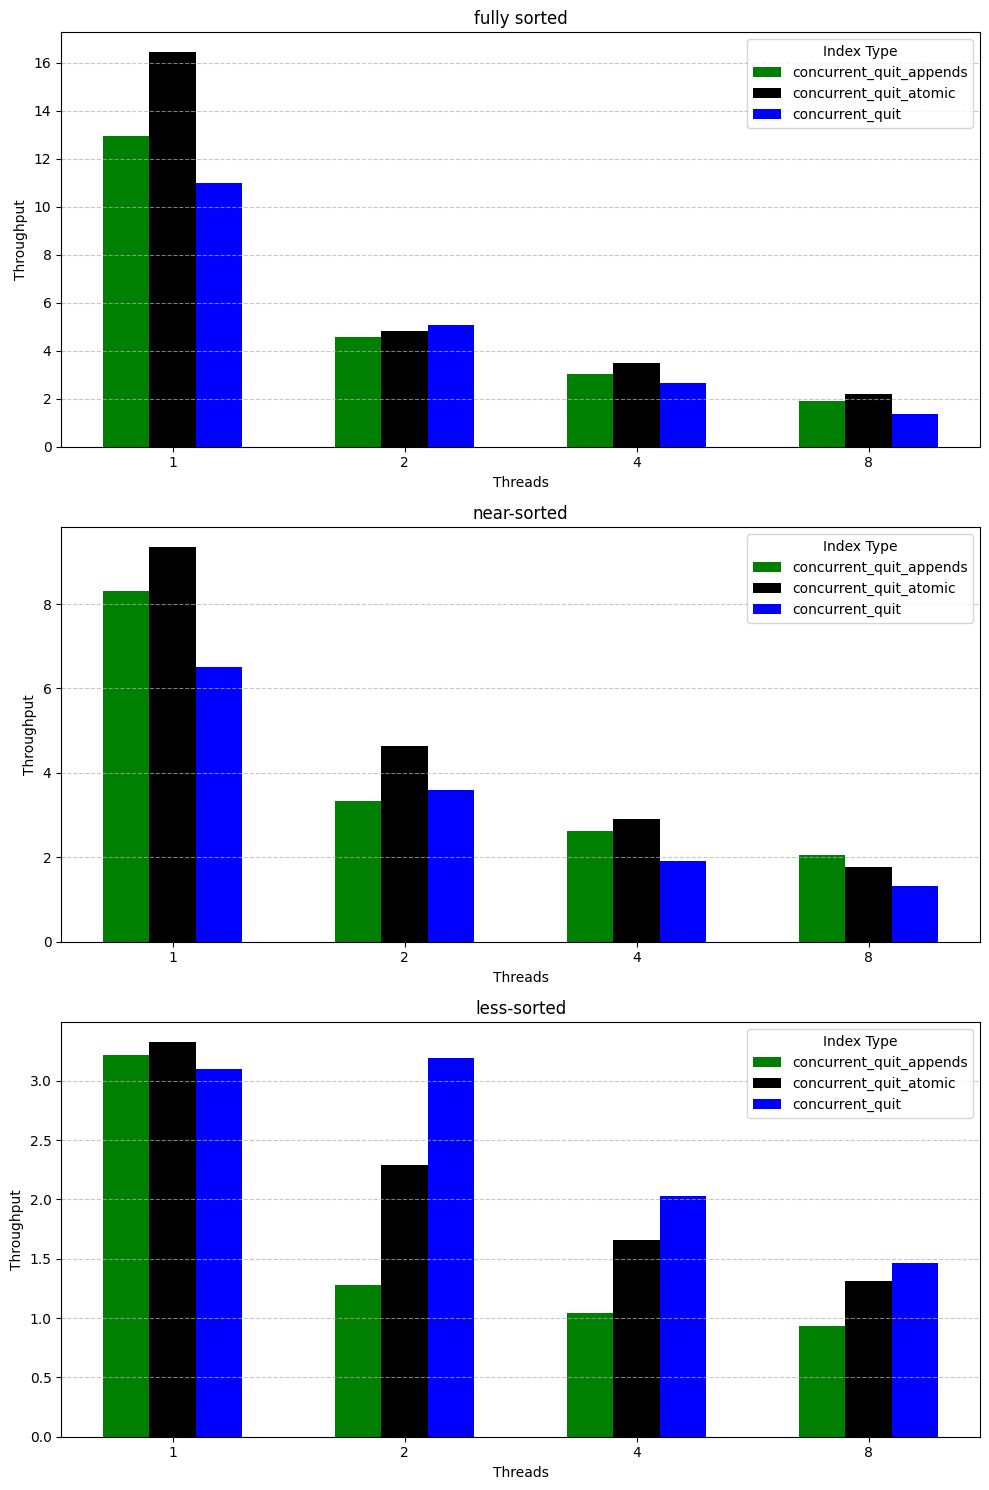

In [67]:
# Create a figure and a set of subplots based on the number of unique K values
fig, axes = plt.subplots(
    nrows=len(k_values),
    ncols=1,
    figsize=(10, 5 * len(k_values)),
    sharex=False
)
# Ensure 'axes' is an array even if there's only one subplot
if len(k_values) == 1:
    axes = [axes]

bar_width = 0.2
# Define colors for each index_type to maintain consistency across subplots
colors_map = {
    "concurrent_simple": "grey",
    "concurrent_quit": "blue",
    "concurrent_quit_appends": "green",
    "concurrent_quit_atomic": "black"
}


for i, k in enumerate(k_values):
    ax = axes[i]
    # Filter DataFrame by the current K value and sort using pandas
    # k_df = preload_df[preload_df["K"] == k].sort_values(by=["index_type", "threads"])
    # preload_df.filter(pl.col("index_type") == index).sort(["K", "threads"])
    k_df = preload_df.filter(pl.col("K") == k).sort(by = ["K", "threads"])

    # Calculate positions for bars for each index_type to avoid overlap
    x = range(len(thread_values))
    num_index_types = len(index_types)
    # The starting offset for the first bar group
    offset_start = -((num_index_types - 1) / 2) * bar_width

    for idx_type_idx, index_type in enumerate(index_types):
        # Calculate the actual positions for the bars of the current index_type
        # These positions are offset from the main x-ticks (thread_values)
        current_x_positions = [
            val + offset_start + idx_type_idx * bar_width
            for val in x
        ]
        # Filter for the current index_type and sort by threads using pandas
        # type_df = k_df[k_df["index_type"] == index_type].sort_values("threads")
        type_df = k_df.filter(pl.col("index_type") == index_type).sort("threads")
        ax.bar(
            current_x_positions,
            type_df["throughput"],
            width=bar_width,
            label=index_type,
            color=colors_map[index_type]
        )

    ax.set_xticks(x)
    ax.set_xticklabels(thread_values)
    ax.set_xlabel("Threads")
    ax.set_ylabel("Throughput")
    ax.set_title(f"{sortedness_values[k]}")
    ax.legend(title="Index Type")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.show()
plt.savefig("inserts-july2-separate-sortedness.pdf")

# Old

In [20]:
# fetch index types
index_types = df["index_type"].unique().to_list()

# filter and group dfs by index types
grouped_dfs = {}
for index in index_types:
    filtered_df = preload_df.filter(pl.col("index_type") == index).sort("K")
    grouped_dfs[index] = filtered_df

k_values = sorted(preload_df["K"].unique().to_list())

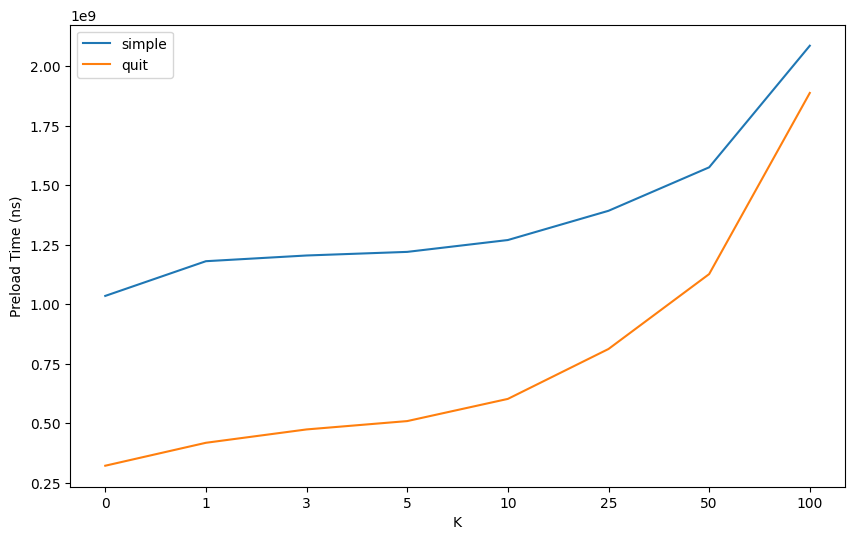

In [21]:
x_positions = np.arange(len(k_values))

plt.figure(figsize=(10,6))

for index, index_df in grouped_dfs.items():
    plt.plot(x_positions, index_df["preload_time"], label=index)

plt.xticks(x_positions, k_values)
plt.xlabel("K")
plt.ylabel("Preload Time (ns)")
plt.legend()
plt.show()